## Import Modules and Enter inputs for simulation 

In [1]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from ochre import Dwelling
from ochre.utils import default_input_path
from ochre.utils.schedule import ALL_SCHEDULE_NAMES
from datetime import timedelta, datetime


# input locations, taken from OCHRE working directory
inputXML = '\\bldg0002631-up06\\' # sample building
inputSCHED = inputXML # same folder as building data
weather = 'USA_OR_Portland.Intl.AP.726980_TMY3.epw' # weather file is in the weather folder


Start = dt.datetime(2018, 1, 11, 0, 0) # year, month, date, hour, minute
Duration = 1 # in days
t_res = 1 # time resolution in minutes

Tcontrol_SHEDF = 126
Tcontrol_deadbandF = 10

Tcontrol_LOADF = 130
Tcontrol_LOADdeadbandF = 2

TbaselineF = 130
TdeadbandF = 7

Tinit = 128


# Schedule variant
my_schedule = {
    'M_LU_time': '05:00',
    'M_LU_duration': 1,
    'M_S_time': '06:00',
    'M_S_duration': 4,
    'E_ALU_time': '16:00',
    'E_ALU_duration': 1,
    'E_S_time': '17:00',
    'E_S_duration': 3
}



#########################################
#     TEMPERATURE CONVERSIONS F to C
#########################################

def f_to_c(temp_f): 
    return (temp_f - 32) * 5/9

def f_to_c_DB(temp_f):
    return 5/9 * temp_f

Tcontrol_SHEDC = f_to_c(Tcontrol_SHEDF)
Tcontrol_deadbandC = f_to_c_DB(Tcontrol_deadbandF)
Tcontrol_LOADC = f_to_c(Tcontrol_LOADF)
Tcontrol_LOADdeadbandC = f_to_c_DB(Tcontrol_LOADdeadbandF)
TbaselineC = f_to_c(TbaselineF)
TdeadbandC = f_to_c_DB(TdeadbandF)
TinitC = f_to_c(Tinit)

print('done')

done


## Run simulation

In [2]:
# build path for original schedule file and saveto filtered schedule file
original_sched_file = os.path.join(default_input_path, "Input Files" + inputSCHED, 'schedules.csv')
filtered_sched_file = os.path.join(default_input_path, "Input Files" + inputSCHED, 'filtered_schedules.csv')
results_dir = os.path.join(default_input_path, "Results")
os.makedirs(results_dir, exist_ok=True)

#########################################
#    Remove Unavailable Sched. Loads
#########################################

def removeItems(filename_path):
    df_sched = pd.read_csv(filename_path)

    valid_schedule_names = set(ALL_SCHEDULE_NAMES.keys())
    filtered_columns = [col for col in df_sched.columns if col in valid_schedule_names]
    dropped_columns = [col for col in df_sched.columns if col not in filtered_columns]

    print("\u274c Dropped:", dropped_columns)

    df_sched_filtered = df_sched[filtered_columns]
    df_sched_filtered.to_csv(filtered_sched_file, index=False)
    return filtered_sched_file, df_sched_filtered

# new filtered schedule file
filtered_sched_file, df_schedule = removeItems(original_sched_file)

# Create total hot water draw per row
df_schedule['hot_water_total'] = (
    df_schedule['hot_water_dishwasher'] +
    df_schedule['hot_water_clothes_washer'] +
    df_schedule['hot_water_fixtures']
)


#########################################
#         DWELLING ARGS
#########################################

dwelling_args = {
    "start_time": Start,
    "time_res": dt.timedelta(minutes=t_res),
    "duration": dt.timedelta(days=Duration),
    "hpxml_file": os.path.join(default_input_path, "Input Files" + inputXML, 'in.XML'),
    "hpxml_schedule_file": filtered_sched_file,
    "weather_file": os.path.join(default_input_path, "Weather", weather),
    "verbosity": 7,
    "Equipment": {
        "Water Heating": {
            "Initial Temperature (C)": TinitC, 
            "hp_only_mode": False,
            "Max Tank Temperature (C)": 70, # 158F
            "Upper Node": 3, # 3 is normal
            "Lower Node": 10, # 10 is normal
            "Upper Node Weight": 0.75, # [0, 1]...Lower auto calcs
            "Efficiency Coefficient": 0,
        },
    }
    
}

#########################################
#     SCHEDULED CONTROL FUNCTION
#########################################


def determine_hpwh_control(sim_time, current_temp_c, sched_cfg, **kwargs):
    ctrl_signal = {
        'Water Heating': {
            'Setpoint': TbaselineC,
            'Deadband': TdeadbandC,
            'Load Fraction': 1,
        }
    }

    base_date = sim_time.date()
    
    def get_time_range(key_prefix):
        start = pd.to_datetime(f"{base_date} {sched_cfg[f'{key_prefix}_time']}")
        end = start + pd.Timedelta(hours=sched_cfg[f'{key_prefix}_duration'])
        return start, end

    # Time intervals
    ranges = {
        'M_LU': get_time_range('M_LU'),
        'M_S': get_time_range('M_S'),
        'E_ALU': get_time_range('E_ALU'),
        'E_S': get_time_range('E_S'),
    }

    if ranges['M_LU'][0] <= sim_time < ranges['M_LU'][1] or ranges['E_ALU'][0] <= sim_time < ranges['E_ALU'][1]:
        ctrl_signal['Water Heating'].update({
            'Setpoint': Tcontrol_LOADC,
            'Deadband': Tcontrol_LOADdeadbandC
        })
    elif ranges['M_S'][0] <= sim_time < ranges['M_S'][1] or ranges['E_S'][0] <= sim_time < ranges['E_S'][1]:
        ctrl_signal['Water Heating'].update({
            'Setpoint': Tcontrol_SHEDC,
            'Deadband': Tcontrol_deadbandC
        })

    return ctrl_signal


#########################################
#   SIMULATION WITH CUSTOM SCHEDULE
#########################################

def simulate_hpwh_schedule_variant(sched_cfg, determine_hpwh_control):

    # Baseline run
    base_dwelling = Dwelling(name="HPWH Baseline Variant", **dwelling_args)

    for t_base in base_dwelling.sim_times:
        assert base_dwelling.current_time == t_base
        base_ctrl = {
            "Water Heating": {
                "Setpoint": TbaselineC, #TbaselineC
                "Deadband": TdeadbandC, #TdeadbandC
                "Load Fraction": 1
            }
        }
        base_dwelling.update(control_signal=base_ctrl)

    df_base_variant, _, _ = base_dwelling.finalize()

    
    sim_dwelling = Dwelling(name="HPWH Scheduled Variant", **dwelling_args)
    hpwh_unit = sim_dwelling.get_equipment_by_end_use('Water Heating')

    for sim_time in sim_dwelling.sim_times:
        assert sim_dwelling.current_time == sim_time
        current_setpt = hpwh_unit.schedule.loc[sim_time, 'Water Heating Setpoint (C)']
        
        control_cmd = determine_hpwh_control(
            # hr=sim_time.hour,
            sim_time = sim_time,
            current_temp_c=current_setpt,
            sched_cfg=sched_cfg
        )
        sim_dwelling.update(control_signal=control_cmd)

    df_sched_variant, _, _ = sim_dwelling.finalize()


    # Save output
    df_sched_variant.to_csv(os.path.join(results_dir, 'hpwh_schedule_variant_controlled.csv'))
    df_base_variant.to_csv(os.path.join(results_dir, 'hpwh_schedule_variant_baseline.csv'))

    print("Variant simulation complete.")
    print(f"Controlled: {os.path.join(results_dir, 'hpwh_schedule_variant_controlled.csv')}")
    print(f"Baseline:   {os.path.join(results_dir, 'hpwh_schedule_variant_baseline.csv')}")

    return df_sched_variant, df_base_variant

#########################################
#       RUN SIM
#########################################

df_sched_variant, df_base_variant = simulate_hpwh_schedule_variant(my_schedule, determine_hpwh_control)

print('Done!')

❌ Dropped: ['hot_tub_pump', 'hot_tub_heater']
2026-02-09 13:52:53.689051 - HPWH Baseline Variant at 2018-01-11 00:00:00: Initializing HPWH Baseline Variant (OCHRE v0.9.1)
2026-02-09 13:52:53.690555 - HPWH Baseline Variant at 2018-01-11 00:00:00: Removing previous results file: C:\Users\danap\anaconda3\Lib\site-packages\ochre\defaults\Input Files\bldg0002631-up06\HPWH Baseline Variant.csv
2026-02-09 13:52:53.695567 - HPWH Baseline Variant at 2018-01-11 00:00:00: Removing previous results file: C:\Users\danap\anaconda3\Lib\site-packages\ochre\defaults\Input Files\bldg0002631-up06\HPWH Baseline Variant_metrics.csv
2026-02-09 13:52:53.695567 - HPWH Baseline Variant at 2018-01-11 00:00:00: Removing previous results file: C:\Users\danap\anaconda3\Lib\site-packages\ochre\defaults\Input Files\bldg0002631-up06\HPWH Baseline Variant_hourly.csv
2026-02-09 13:52:53.696565 - HPWH Baseline Variant at 2018-01-11 00:00:00: Removing previous results file: C:\Users\danap\anaconda3\Lib\site-packages\ochr

## Plot Inputs

In [3]:
# for col in df_base_variant.columns:
#     print(col)


T_Layers = []
cols = np.arange(0, 13, 1)

for i in cols:
    column_name = f'Water Heating Tank Temperature Node {i} (C)'
    if column_name in df_sched_variant.columns:
        col_values = df_sched_variant[column_name]
        T_Layers.append(col_values)



###########################################
#      PLOT
###########################################

power_col = 'Water Heating Electric Power (kW)'
tank_col = 'Hot Water Outlet Temperature (C)'
avg_tank_col = 'Hot Water Average Temperature (C)'
draw_col = 'Hot Water Delivered (L/min)'
# test = 'Total Water Heating Delivered (kWh)'
# draw_col = 'Water Heating Heat Pump COP (-)'
dbUP_col = 'Water Heating Deadband Upper Limit (C)'
dbLOW_col = 'Water Heating Deadband Lower Limit (C)'
Ttrue_col = 'Water Heating Control Temperature (C)'

def c2f(x):
    return 9/5*x + 32

Tbaseline_resultsF = c2f(df_base_variant[Ttrue_col])
Tcontrol_resultsF = c2f(df_sched_variant[Ttrue_col])

Tbase_avg = c2f(df_base_variant[avg_tank_col])
Tcon_avg = c2f(df_sched_variant[avg_tank_col])

power_base = df_base_variant[power_col]
power_control = df_sched_variant[power_col]

dbUpper = c2f(df_base_variant[dbUP_col])
dbLower = c2f(df_base_variant[dbLOW_col])
dbUpper_sched = c2f(df_sched_variant[dbUP_col])
dbLower_sched = c2f(df_sched_variant[dbLOW_col])

Ttrue = c2f(df_base_variant[Ttrue_col])
Ttrue_sched = c2f(df_sched_variant[Ttrue_col])



dataRes = 1


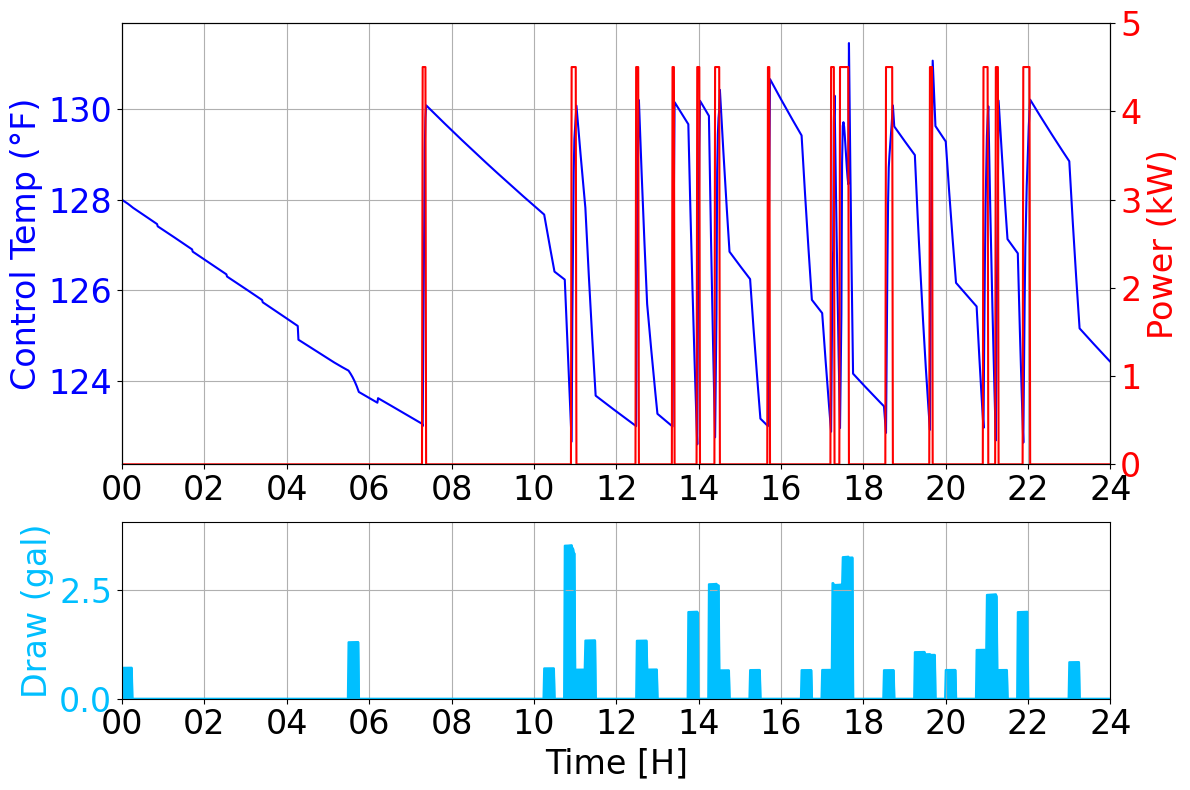

In [4]:
import matplotlib.pyplot as plt

A = 24  # font size
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 0.4]})

###########################################
#      TANK TEMP + POWER
###########################################
ax1 = axes[0]
ax2 = ax1.twinx()

baseColor = 'blue'
pwrColor = 'red'

# X-values in hours (0–24)
x_hours = df_base_variant.index.hour + df_base_variant.index.minute / 60

# Plot tank temperature
ax1.plot(x_hours, Tbaseline_resultsF, color=baseColor, label='Tank Temp (Baseline)')
ax1.set_ylabel("Control Temp (°F)", color=baseColor, fontsize=A)
ax1.tick_params(axis='y', labelcolor=baseColor, labelsize=A)

# Plot power
ax2.plot(x_hours, power_base, label='Power', color=pwrColor)
ax2.set_ylabel("Power (kW)", color=pwrColor, fontsize=A)
ax2.tick_params(axis='y', labelcolor=pwrColor, labelsize=A)

ax1.grid(True)
ax2.set_ylim(ymin=0, ymax=5)

###########################################
#      WATER DRAW
###########################################
ax3 = axes[1]

l_2_gal = 15 * 0.264172
draw = df_base_variant[draw_col] * l_2_gal
drawMax = max(draw) * 1.15 if max(draw) != 0 else 0.5

ax3.plot(x_hours, draw, color='deepskyblue', label='Water Draw')
ax3.set_ylabel("Draw (gal)", color='deepskyblue', fontsize=A)
ax3.tick_params(axis='y', labelcolor='deepskyblue', labelsize=A)
ax3.fill_between(x_hours, y1=0, y2=draw, color='deepskyblue')
ax3.set_ylim(ymin=0, ymax=drawMax)
ax3.grid(True)

###########################################
#     X-AXIS formatting
###########################################
for ax in axes:
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 2))
    ax.set_xticklabels([f"{h:02d}" for h in range(0, 25, 2)])
    ax.tick_params(axis='x', labelsize=A)

axes[-1].set_xlabel("Time [H]", fontsize=A)

plt.tight_layout()
plt.show()


In [ ]:
def get_max_cop_in_period(df, start, end, cop_col):
    """Return the maximum COP within the given time window [start, end)."""
    df_period = df.loc[(df.index >= start) & (df.index < end), cop_col]
    if df_period.empty:
        return None
    return df_period.max()


fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True,
                         gridspec_kw={'height_ratios': [1, 1, 0.4]})

###########################################
#      BASELINE PLOT
###########################################

ax1 = axes[0]
ax2 = ax1.twinx()

A = 24
baseColor = 'blue'
pwrColor = 'red'

COP_col = 'Water Heating Heat Pump COP (-)'

COP_base = df_base_variant[COP_col]
COP_sched = df_sched_variant[COP_col]

COPbase_avg = sum(COP_base) / len(COP_base)
COPsched_avg = sum(COP_sched) / len(COP_sched)

def ET(TF, COP, Tset):
    c = 0.291
    p = 8.3454
    V = 50
    return c * p * V * (Tset - TF) / COP


COPconstant = 4.16748

ETbase = ET(Ttrue, COPconstant, TbaselineF)
ETshed = ET(Ttrue_sched, COPconstant, TbaselineF)  # example fixed COP
ETup_base = ET(dbLower, COPconstant, TbaselineF)
ETlow_shed = ET(dbUpper_sched, COPconstant, TbaselineF)

# ETlayer8 = ET(layer8, COPconstant, TbaselineF)

ETmax = max(max(ETbase), max(ETshed)) * 1.75 / 1000

ax1.plot(df_base_variant.index, ETup_base / 1000, color=baseColor,
         label='Tweighted', linestyle='--')
ax1.plot(df_base_variant.index, ETbase / 1000, color=baseColor, label='Tweighted')
ax1.set_ylabel("(Normal)\nEnergyTake (kWh)", color=baseColor, fontsize=A)
ax1.tick_params(axis='y', labelcolor=baseColor, labelsize=A)

ax2.plot(df_base_variant.index, power_base, label='Power', color=pwrColor)
ax2.set_ylabel("Power (kW)", color=pwrColor, fontsize=A)
ax2.tick_params(axis='y', labelcolor=pwrColor, labelsize=A)
ax1.set_ylim(ymin=0, ymax=ETmax)
ax2.set_ylim(ymin=0, ymax=0.6)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
ax1.yaxis.set_major_locator(plt.MaxNLocator(6))

###########################################
#      CONTROL PLOT
###########################################

ax3 = axes[1]
ax4 = ax3.twinx()

loadColor = 'xkcd:light grass green'
shedColor = 'xkcd:orangey yellow'
controlColor = 'darkorchid'


ax3.plot(df_sched_variant.index, ETshed / 1000, color=controlColor, label='t_control')
ax3.set_ylabel("(LoadUp/Shed)\nEnergyTake (kWh)", color=controlColor, fontsize=A)
ax3.tick_params(axis='y', labelcolor=controlColor, labelsize=A)

ax4.plot(df_sched_variant.index, power_control, label='Power', color=pwrColor)
ax4.set_ylabel("Power (kW)", color=pwrColor, fontsize=A)
ax4.tick_params(axis='y', labelcolor=pwrColor, labelsize=A)
ax3.set_ylim(ymin=0, ymax=ETmax)
ax4.set_ylim(ymin=0, ymax=0.6)
ax3.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
ax3.yaxis.set_major_locator(plt.MaxNLocator(6))

###########################################
#      Water Draw Plot
###########################################

ax5 = axes[2]
l_2_gal = 15 * 0.264172
draw = df_sched_variant[draw_col] * l_2_gal
drawMax = max(draw) * 1.15 if max(draw) != 0 else 0.5

ax5.plot(df_sched_variant.index, draw, color='deepskyblue', label='Water Draw')
ax5.set_ylabel("Water\nDraw (gal)", color='deepskyblue', fontsize=A)
ax5.tick_params(axis='y', labelcolor='deepskyblue', labelsize=A)
ax5.fill_between(df_sched_variant.index, y1=0, y2=draw, color='deepskyblue')
ax5.set_ylim(ymin=0, ymax=drawMax)
ax5.yaxis.set_major_locator(plt.MaxNLocator(3))





###########################################
#      Highlight Control Regions
###########################################

base_date = df_sched_variant.index.date[0].strftime('%Y-%m-%d')

def get_time_range(key_prefix):
    start = pd.to_datetime(f"{base_date} {my_schedule[f'{key_prefix}_time']}")
    end = start + pd.Timedelta(hours=my_schedule[f'{key_prefix}_duration'])
    return start, end

ETup_control = pd.Series(index=df_sched_variant.index, dtype=float)
ETlow_control = pd.Series(index=df_sched_variant.index, dtype=float)

# Default: uncontrolled
Tlower_base = TbaselineF - TdeadbandF   # Lower deadband
Tupper_base = TbaselineF                # Upper deadband = setpoint
ETup_control[:] = ET(Tlower_base, COPconstant, TbaselineF)
ETlow_control[:] = ET(Tupper_base, COPconstant, TbaselineF)


# Define control periods (aligned with your my_schedule keys)
periods = {
    "M_LU": {   # Morning Load Up
        "Tset": Tcontrol_LOADF,
        "Deadband": Tcontrol_LOADdeadbandF,
        "color": loadColor,
        "type": "LoadUp"
    },
    "M_S": {    # Morning Shed
        "Tset": Tcontrol_SHEDF,
        "Deadband": Tcontrol_deadbandF,
        "color": shedColor,
        "type": "Shed"
    },
    "E_ALU": {  # Evening Additional Load Up
        "Tset": Tcontrol_LOADF,
        "Deadband": Tcontrol_LOADdeadbandF,
        "color": loadColor,
        "type": "LoadUp"
    },
    "E_S": {    # Evening Shed
        "Tset": Tcontrol_SHEDF,
        "Deadband": Tcontrol_deadbandF,
        "color": shedColor,
        "type": "Shed"
    }
}



# Overwrite only for controlled periods
for key, info in periods.items():
    start, end = get_time_range(key)
    mask = (df_sched_variant.index >= start) & (df_sched_variant.index < end)

    # Highlight control period on both relevant plots
    for ax in [ax1, ax3]:
        ax.fill_between(
            df_sched_variant.index, y1=0, y2=1,
            where=mask,
            color=info["color"], alpha=0.2,
            transform=ax.get_xaxis_transform())
    
    
    max_cop = 4.4
    

    Tlower_deadband = info["Tset"] - info["Deadband"]
    ETup_control.loc[mask] = ET(Tlower_deadband, max_cop, TbaselineF)
    
    # Upper deadband line
    Tupper_deadband = info["Tset"]
    ETlow_control.loc[mask] = ET(Tupper_deadband, max_cop, TbaselineF)




ax3.plot(df_sched_variant.index, ETup_control/1000, color=controlColor, linestyle='--', label='Upper Deadband ET')
ax3.plot(df_sched_variant.index, ETlow_control/1000, color=controlColor, linestyle='--', label='Lower Deadband ET')



###########################################
#     STYLE
###########################################

for ax in [ax1, ax3, ax5]:
    ax.grid(True)

axes[-1].set_xlabel("Time (H:M)", fontsize=A)
plt.tight_layout()

# Format x-axis to HH:MM
time_format = mdates.DateFormatter('%H:%M')
for ax in axes:
    ax.xaxis.set_major_formatter(time_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.tick_params(axis='x', labelrotation=65, labelsize=A)
    ax.set_xlim(Start, Start + timedelta(days=Duration))

plt.show()


In [ ]:
base = power_base.sum()/60
control = power_control.sum()/60

###########################################
#   Energy Comparison in Control Periods
###########################################

def compute_energy_from_power(df, start, end, power_series):
    """Compute energy (kWh) from power (kW) in [start, end) given 1-min resolution."""
    period = power_series.loc[(df.index >= start) & (df.index < end)]
    return period.sum() / 60.0  # minutes → hours

def percent_diff(base, control):
    return (control - base) / base * 100


# --- Get periods ---
M_S_start, M_S_end = get_time_range("M_S")
E_S_start, E_S_end = get_time_range("E_S")


# --- Compute energies using POWER (baseline vs control) ---
E_base_MS = compute_energy_from_power(df_base_variant, M_S_start, M_S_end, power_base)
E_control_MS = compute_energy_from_power(df_sched_variant, M_S_start, M_S_end, power_control)

E_base_EALU = compute_energy_from_power(df_base_variant, E_S_start, E_S_end, power_base)
E_control_EALU = compute_energy_from_power(df_sched_variant, E_S_start, E_S_end, power_control)

# --- Totals ---
E_base_total = E_base_MS + E_base_EALU
E_control_total = E_control_MS + E_control_EALU

# --- Percent differences ---
MS_diff = percent_diff(E_base_MS, E_control_MS)
EALU_diff = percent_diff(E_base_EALU, E_control_EALU)
Total_diff = percent_diff(E_base_total, E_control_total)



# print(f"Max COP (base): {max(COP_base):.2f}")
# print(f"Median COP (base): {COP_base.median():.2f}")

print("\n------------------------------------------------------------------------------")
print("Total Day (kWh)")
print("------------------------------------------------------------------------------")
print(f"Energy (base): {base:.2f} kW")
print(f"Energy (control): {control:.2f} kW")
print(f"%Diff: {100*(control-base)/base:+.2f}%")


print("\n------------------------------------------------------------------------------")
print("Shed Periods Only (kWh)")
print("------------------------------------------------------------------------------")
print(f"Morning Shed:    Baseline: {E_base_MS:.2f}     Control: {E_control_MS:.2f}    %Diff: {MS_diff:+.2f}%")
print(f"Evening Shed:    Baseline: {E_base_EALU:.2f}     Control: {E_control_EALU:.2f}    %Diff: {EALU_diff:+.2f}%")
print(f"Total Shed:      Baseline: {E_base_total:.2f}     Control: {E_control_total:.2f}    %Diff: {Total_diff:+.2f}%")


In [ ]:
import os
import pandas as pd
import re

def aggregate_by_setpoint(work_dir):
    """
    Aggregate all per-deadband HPWH control files for the same setpoint (ShedXXX)
    into a single master file per setpoint, preserving the filename prefix.
    """
    # List all per-deadband files
    all_files = [f for f in os.listdir(work_dir) if f.endswith("_Control.parquet") and "_DB" in f]

    # Group files by prefix + setpoint
    setpoint_groups = {}
    for f in all_files:
        # Match <prefix>_ShedXXX_DB*_Control.parquet
        match = re.match(r"(.+_)(Shed\d+)_DB\d+F_Control\.parquet", f)
        if match:
            prefix, setpoint = match.groups()
            key = prefix + setpoint
            setpoint_groups.setdefault(key, []).append(os.path.join(work_dir, f))

    # Aggregate each group
    for key, files in setpoint_groups.items():
        all_dfs = []
        for file_path in files:
            df = pd.read_parquet(file_path)
            df["SourceFile"] = os.path.basename(file_path)
            all_dfs.append(df)
        df_master = pd.concat(all_dfs, ignore_index=True)

        # Master file preserves the original prefix
        master_file = os.path.join(work_dir, f"{key}_Control3.parquet")
        df_master.to_parquet(master_file, index=False)
        print(f"Aggregated {len(files)} files for {key} → {master_file}")

# Run the aggregation
aggregate_by_setpoint(WORKING_DIR)
